In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,8)
plt.style.use('seaborn-bright')
from datetime import timedelta
from keras.models import *
from keras.layers import *
from sklearn.preprocessing import *
import seaborn as sns

In [6]:
series = pd.read_csv('daily-total-female-births.csv', index_col=0, parse_dates=True)
series.head()

values = series.values

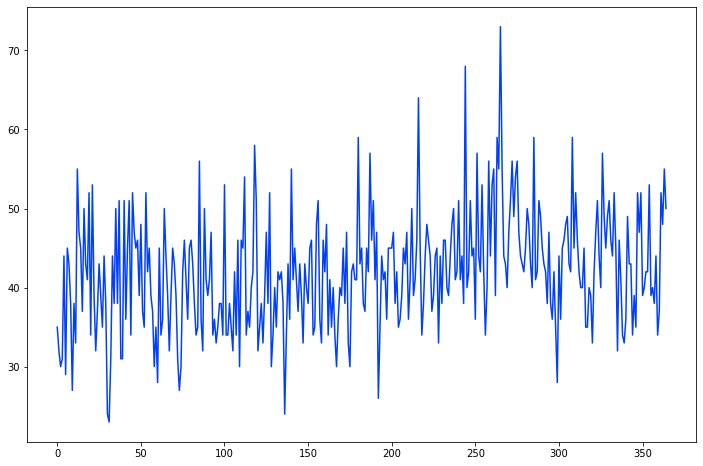

In [7]:
plt.plot(values)
plt.show()

In [8]:
from sklearn.metrics import mean_absolute_error 
from xgboost import XGBRegressor

from pandas import DataFrame
from pandas import concat

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

C:\Users\moham\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [9]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]

In [14]:
# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
	# transform list into array
	train = np.array(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = XGBRegressor(objective='reg:squarederror', n_estimators=1000,
				learning_rate=0.10,
				subsample=0.5,
				colsample_bytree=1, 
				max_depth=5,
			)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict(np.array([testX]))
	return yhat[0]

In [15]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = xgboost_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('->Expected=%.1f, Predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, -1], predictions

In [18]:
data = series_to_supervised(values, n_in=6)

mae, y, yhat = walk_forward_validation(data, 24)
print('MAE: %.3f' % mae)

->Expected=49.0, Predicted=32.0
->Expected=43.0, Predicted=39.7
->Expected=43.0, Predicted=46.9
->Expected=34.0, Predicted=38.5
->Expected=39.0, Predicted=45.8
->Expected=35.0, Predicted=49.6
->Expected=52.0, Predicted=42.6
->Expected=47.0, Predicted=39.7
->Expected=52.0, Predicted=42.9
->Expected=39.0, Predicted=37.8
->Expected=40.0, Predicted=43.1
->Expected=42.0, Predicted=44.8
->Expected=42.0, Predicted=43.2
->Expected=53.0, Predicted=42.0
->Expected=39.0, Predicted=40.8
->Expected=40.0, Predicted=36.8
->Expected=38.0, Predicted=43.0
->Expected=44.0, Predicted=54.6
->Expected=34.0, Predicted=44.2
->Expected=37.0, Predicted=33.4
->Expected=52.0, Predicted=34.1
->Expected=48.0, Predicted=45.5
->Expected=55.0, Predicted=47.3
->Expected=50.0, Predicted=52.9
MAE: 6.694


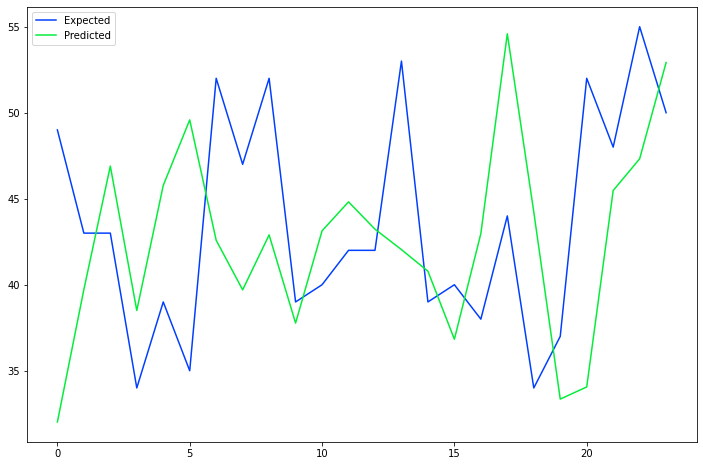

In [19]:
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.show()